# Interpolation



## Better interpolate than never



[interpolation](interpolation)
[Matlab post](http://matlab.cheme.cmu.edu/2012/02/02/better-interpolate-than-never/)

We often have some data that we have obtained in the lab, and we want to solve some problem using the data. For example, suppose we have this data that describes the value of f at time t.



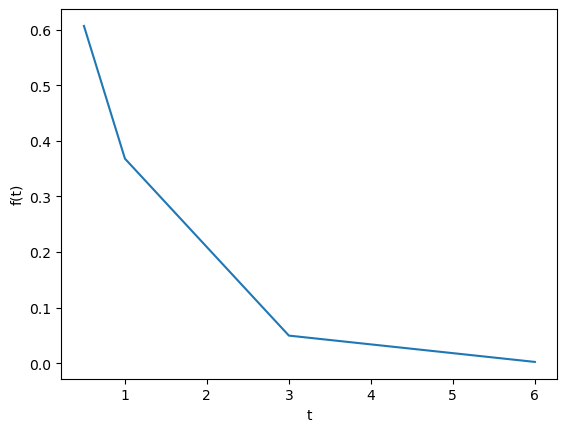

In [1]:
import matplotlib.pyplot as plt

t = [0.5, 1, 3, 6]
f = [0.6065, 0.3679, 0.0498, 0.0025]
plt.plot(t, f)
plt.xlabel("t")
plt.ylabel("f(t)");

### Estimate the value of f at t=2.



This is a simple interpolation problem.



In [2]:
from scipy.interpolate import interp1d

g = interp1d(t, f)  # default is linear interpolation

print(g(2))
print(g([2, 3, 4]))

0.20885
[0.20885    0.0498     0.03403333]


The function we sample above is actually f(t) = exp(-t). The linearly interpolated example is not too accurate.



In [3]:
import numpy as np

print(np.exp(-2))

0.1353352832366127


### Improved interpolation?



We can tell `interp1d` to use a different interpolation scheme such as cubic polynomial splines like this. For nonlinear functions, this may improve the accuracy of the interpolation, as it implicitly includes information about the curvature by fitting a cubic polynomial over neighboring points.



In [4]:
g2 = interp1d(t, f, "cubic")
print(g2(2))
print(g2([2, 3, 4]))

0.10848181818181811
[0.10848182 0.0498     0.08428727]


Interestingly, this is a different value than Matlab's cubic interpolation. Let us show the cubic spline fit.



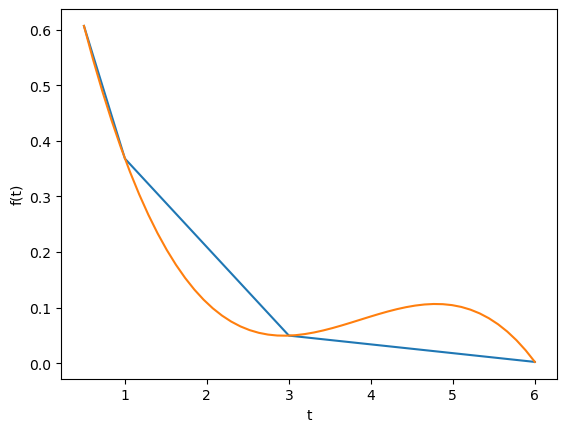

In [5]:
plt.figure()
plt.plot(t, f)
plt.xlabel("t")
plt.ylabel("f(t)")

x = np.linspace(0.5, 6)
fit = g2(x)
plt.plot(x, fit, label="fit");

Wow. That is a weird looking fit. Very different from what Matlab [produces](http://matlab.cheme.cmu.edu/wp-content/uploads/2012/02/interp_methods_02.png). This is a good teaching moment not to rely blindly on interpolation! We will rely on the linear interpolation from here out which behaves predictably.



## The inverse question



It is easy to interpolate a new value of f given a value of t. What if we want to know the time that f=0.2? We can approach this a few ways.



### Method 1



We setup a function that we can use fsolve on. The function will be equal to zero at the time. The second function will look like 0 = 0.2 - f(t). The answer for 0.2=exp(-t) is t = 1.6094. Since we use interpolation here, we will get an approximate answer.



In [6]:
from scipy.optimize import fsolve


def func(t):
    return 0.2 - g(t)


initial_guess = 2
(ans,) = fsolve(func, initial_guess)
print(ans)

2.055642879597611


### Method 2: switch the interpolation order



We can switch the order of the interpolation to solve this problem. An issue we have to address in this method is that the "x" values must be monotonically *increasing*. It is somewhat subtle to reverse a list in python. I will use the cryptic syntax of [::-1] instead of the list.reverse() function or reversed() function. list.reverse() actually reverses the list "in place", which changes the contents of the variable. That is not what I want. reversed() returns an iterator which is also not what I want. [::-1] is a fancy indexing trick that returns a reversed list.



In [7]:
g3 = interp1d(f[::-1], t[::-1])

print(g3(0.2))

2.055642879597611


## A harder problem



Suppose we want to know at what time is 1/f = 100? Now we have to decide what do we interpolate: f(t) or 1/f(t). Let us look at both ways and decide what is best. The answer to $1/exp(-t) = 100$ is 4.6052



### Interpolate on f(t) then invert the interpolated number



In [8]:
def func(t):
    "objective function. we do some error bounds because we cannot interpolate out of the range."
    if t < 0.5:
        t = 0.5
    if t > 6:
        t = 6
    return 100 - 1.0 / g(t)


initial_guess = 4.5
(a1,) = fsolve(func, initial_guess)
print(a1)
print("The %error is {0:%}".format((a1 - 4.6052) / 4.6052))

5.524312896405919
The %error is 19.958154%


### Invert f(t) then interpolate on 1/f



In [9]:
ig = interp1d(t, 1.0 / np.array(f))


def ifunc(t):
    if t < 0.5:
        t = 0.5
    elif t > 6:
        t = 6
    return 100 - ig(t)


initial_guess = 4.5
(a2,) = fsolve(ifunc, initial_guess)
print(a2)
print("The %error is {0:%}".format((a2 - 4.6052) / 4.6052))

3.63107822410148
The %error is -21.152649%


### Discussion



In this case you get different errors, one overestimates and one underestimates the answer, and by a lot: ± 20%. Let us look at what is happening.



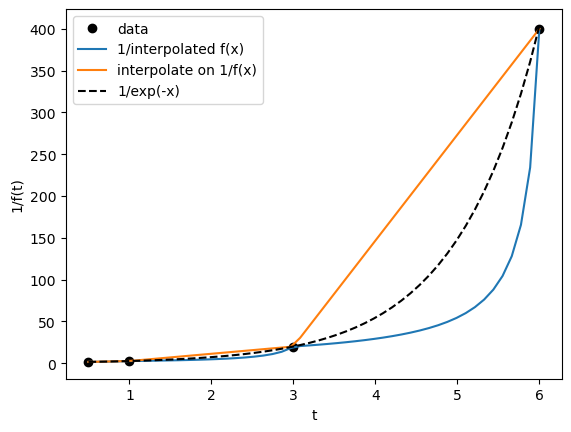

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

t = [0.5, 1, 3, 6]
f = [0.6065, 0.3679, 0.0498, 0.0025]

x = np.linspace(0.5, 6)


g = interp1d(t, f)  # default is linear interpolation
ig = interp1d(t, 1.0 / np.array(f))

plt.figure()
plt.plot(t, 1 / np.array(f), "ko ", label="data")
plt.plot(x, 1 / g(x), label="1/interpolated f(x)")
plt.plot(x, ig(x), label="interpolate on 1/f(x)")
plt.plot(x, 1 / np.exp(-x), "k--", label="1/exp(-x)")
plt.xlabel("t")
plt.ylabel("1/f(t)")
plt.legend(loc="best");

You can see that the 1/interpolated f(x) underestimates the value, while interpolated (1/f(x)) overestimates the value. This is an example of where you clearly need more data in that range to make good estimates. Neither interpolation method is doing a great job. The trouble in reality is that you often do not know the real function to do this analysis. Here you can say the time is probably between 3.6 and 5.5 where 1/f(t) = 100, but you can not read much more than that into it. If you need a more precise answer, you need better data, or you need to use an approach other than interpolation. For example, you could fit an exponential function to the data and use that to estimate values at other times.

So which is the best to interpolate? I think you should interpolate the quantity that is linear in the problem you want to solve, so in this case I think interpolating 1/f(x) is better. When you use an interpolated function in a nonlinear function, strange, unintuitive things can happen. That is why the blue curve looks odd. Between data points are linear segments in the original interpolation, but when you invert them, you cause the curvature to form.



## Interpolation of data



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/01/interpolation-of-data/)

When we have data at two points but we need data in between them we use interpolation. Suppose we have the points (4,3) and (6,2) and we want to know the value of y at x=4.65, assuming y varies linearly between these points. we use the interp1d command to achieve this. The syntax in python is slightly different than in matlab.



In [11]:
from scipy.interpolate import interp1d

x = [4, 6]
y = [3, 2]

ifunc = interp1d(x, y)

print(ifunc(4.65))


ifunc = interp1d(x, y, bounds_error=False)  # do not raise error on out of bounds
print(ifunc([4.65, 5.01, 4.2, 9]))

2.675
[2.675 2.495 2.9     nan]


The default interpolation method is simple linear interpolation between points. Other methods exist too, such as fitting a cubic spline to the data and using the spline representation to interpolate from.



In [12]:
from scipy.interpolate import interp1d

x = [1, 2, 3, 4]
y = [1, 4, 9, 16]  # y = x^2

xi = [1.5, 2.5, 3.5]  # we want to interpolate on these values
y1 = interp1d(x, y)

print(y1(xi))

y2 = interp1d(x, y, "cubic")
print(y2(xi))

import numpy as np

print(np.array(xi) ** 2)

[ 2.5  6.5 12.5]
[ 2.25  6.25 12.25]
[ 2.25  6.25 12.25]


In this case the cubic spline interpolation is  more accurate than the linear interpolation. That is because the underlying data was polynomial in nature, and a spline is like a polynomial. That may not always be the case, and you need some engineering judgement to know which method is best.



## Interpolation with splines



When you do not know the functional form of data to fit an equation, you can still fit/interpolate with splines.



Optimization terminated successfully.
         Current function value: -0.575221
         Iterations: 12
         Function evaluations: 24


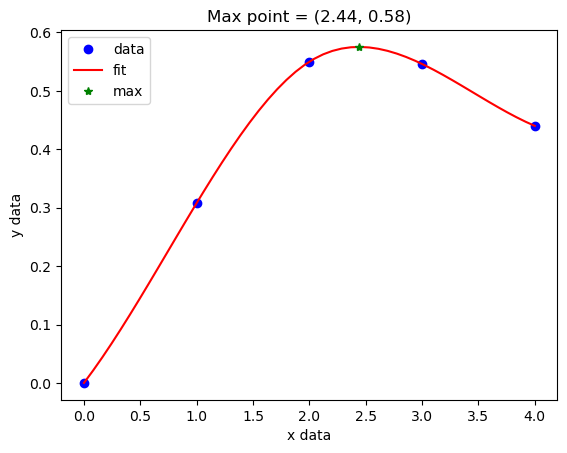

In [13]:
# use splines to fit and interpolate data
from scipy.interpolate import interp1d
from scipy.optimize import fmin
import numpy as np
import matplotlib.pyplot as plt

x = np.array([0, 1, 2, 3, 4])
y = np.array([0.0, 0.308, 0.55, 0.546, 0.44])

# create the interpolating function
f = interp1d(x, y, kind="cubic", bounds_error=False)

# to find the maximum, we minimize the negative of the function. We
# cannot just multiply f by -1, so we create a new function here.
f2 = interp1d(x, -y, kind="cubic")
xmax = fmin(f2, 2.5)

xfit = np.linspace(0, 4)

plt.plot(x, y, "bo")
plt.plot(xfit, f(xfit), "r-")
plt.plot(xmax, f(xmax), "g*")
plt.legend(["data", "fit", "max"], loc="best", numpoints=1)
plt.xlabel("x data")
plt.ylabel("y data")
plt.title("Max point = ({0:1.2f}, {1:1.2f})".format(float(xmax), float(f(xmax))));

There are other good examples at [http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html](http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)

